In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cartopy.crs as crs
#import cartopy.feature as cfeature
import json
import sys
!{sys.executable} -m pip install PyAthena
import plotly
from pyathena import connect
import pandas as pd

from pyathena.async_cursor import AsyncCursor
import boto3

In [2]:
def q2df(q):
    cursor = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2', cursor_class=AsyncCursor).cursor(max_workers=2)
    query_id, future = cursor.execute(q)
    print (query_id, future)
#i=0
#for row in cursor:
#    if i==0:
#        print(row)
#    i+=1
#pd.options.display.float_format = '{:,.4f}'.format
#df = pd.read_sql(q, conn)
#df
    result_set = future.result()
    print(result_set.state)
#    print(result_set.state_change_reason)
#    print(result_set.completion_date_time)
#    print(result_set.submission_date_time)
#    print(result_set.data_scanned_in_bytes)
#    print(result_set.engine_execution_time_in_millis)
#    print(result_set.query_queue_time_in_millis)
    print('Execution Time:', result_set.total_execution_time_in_millis)
#    print(result_set.query_planning_time_in_millis)
#    print(result_set.service_processing_time_in_millis)
#    print(result_set.output_location)
#    print(result_set.description)


    s3_client = boto3.client('s3')

    obj=result_set.output_location[result_set.output_location.rfind('/')+1:]
    print(obj)

    s3_client.download_file('esdis-ems-athena', obj, 'myOut.csv')

    df=pd.read_csv('myOut.csv')  
    return df    

In [3]:
# Climcaps level 2 products where modeled to an Athena table (CLIMCAPS)
# The CLIMCAPS athena table is partitioned by satellite. So all climcaps l2 product 
# from all satellites can be queried toghether or separately by including or excluding
# a particular satellite from the query.
#
# Each longitude/latidue/observation time "pixel" is represented as a row in the climcaps table.
# 3 dimensional arrays (representing altitude) are represented as arrays of records (structures) 
# 4 dimensional arrays are represented by 2d arrays for each "pixel".


q="""
select 
 sat_name_part, 
 obs_date_part, 
 lon, 
 lat, 
 surf_air_temp, 
 air_pres_vars
from 
 sci.climcaps
where
 obs_date_part in ('2021-08-22', '2021-08-24')
 and lon between -90.0 and -60.0
 and lat between 10.0  and 30.0
 and surf_air_temp_qc in ('0', '1')
 and surf_air_temp between 298 and 302
limit 100
"""
df=q2df(q)
df

66adc304-9056-429a-a31a-5d222424437f <Future at 0x7faeb9cec860 state=running>
SUCCEEDED
Execution Time: 2895
66adc304-9056-429a-a31a-5d222424437f.csv


,sat_name_part,obs_date_part,lon,lat,surf_air_temp,air_pres_vars
0,aqua,2021-08-22,-88.780280,21.826332,300.40387,"[{air_pres=1.6063827, air_temp=196.13171, air_..."
1,aqua,2021-08-22,-85.204890,13.595032,300.54858,"[{air_pres=1.6063827, air_temp=197.6155, air_t..."
2,aqua,2021-08-22,-85.193870,10.102197,300.89886,"[{air_pres=1.6063827, air_temp=198.42377, air_..."
3,aqua,2021-08-22,-80.795060,26.440866,301.39800,"[{air_pres=1.6063827, air_temp=197.3016, air_t..."
4,aqua,2021-08-22,-80.787994,13.342240,301.82320,"[{air_pres=1.6063827, air_temp=195.13257, air_..."
...,...,...,...,...,...,...
95,n20,2021-08-24,-75.179070,22.775494,301.57310,"[{air_pres=1.6063827, air_temp=195.79317, air_..."
96,n20,2021-08-24,-75.196045,26.205357,301.48825,"[{air_pres=1.6063827, air_temp=196.15994, air_..."
97,n20,2021-08-24,-72.059760,29.872050,300.28668,"[{air_pres=1.6063827, air_temp=192.22903, air_..."
98,n20,2021-08-24,-71.265330,29.768593,301.44340,"[{air_pres=1.6063827, air_temp=195.18636, air_..."


In [4]:
# CLIMCAPS has variables with depth (altitude) as a third dimension 
# These were modeled in the CLIMCAPS table as arrays of records for 3 dimensional arrays
for i,r in df.iterrows():
    print (i,r)
    #print (json.dumps(r['air_pres_vars']))
    apv_l = r['air_pres_vars'].split('}, {')
    print ()
    print ('top', apv_l[0])
    print ()
    print ('bottom of atmosphere', apv_l[len(apv_l)-1])
    break

0 sat_name_part                                                 aqua
obs_date_part                                           2021-08-22
lon                                                       -88.7803
lat                                                        21.8263
surf_air_temp                                              300.404
air_pres_vars    [{air_pres=1.6063827, air_temp=196.13171, air_...
Name: 0, dtype: object

top [{air_pres=1.6063827, air_temp=196.13171, air_temp_err=2.5386655, air_temp_qc=0, co2_vmr=4.072315E-4, co2_vmr_err=1.5302197E-8, co2_vmr_qc=0, fg_air_temp=195.21802, gp_hgt=75101.19, gp_hgt_err=NaN, gp_hgt_qc=0, mw_air_temp=null, mw_air_temp_err=null, mw_air_temp_qc=null, o3_mmr=1.3152893E-5, o3_mmr_err=3.676169E-6, o3_mmr_qc=0

bottom of atmosphere air_pres=110000.016, air_temp=NaN, air_temp_err=NaN, air_temp_qc=2, co2_vmr=NaN, co2_vmr_err=NaN, co2_vmr_qc=2, fg_air_temp=NaN, gp_hgt=NaN, gp_hgt_err=NaN, gp_hgt_qc=2, mw_air_temp=null, mw_air_temp_err=null, mw_air_

In [5]:
q="""
select 
 sat_name_part, 
 obs_date_part, 
 lon, 
 lat, 
 surf_air_temp, 
 air_pres_vars[30] air_pres_vars_row_30,
 air_pres_vars[30].air_pres air_pres_30,
 air_pres_vars[30].air_temp air_temp_30
from 
 sci.climcaps
where
 obs_date_part in ('2021-08-22', '2021-08-24')
 and lon between -90.0 and -60.0
 and lat between 10.0  and 30.0
 and surf_air_temp_qc in ('0', '1')
 and surf_air_temp between 298.0 and 302.0
limit 100
"""
df=q2df(q)
pd.options.display.float_format = '{:.4f}'.format
df

3a9aefa3-675f-4e3e-b13f-86b793f36b2a <Future at 0x7faeb8d1fc18 state=running>
SUCCEEDED
Execution Time: 2817
3a9aefa3-675f-4e3e-b13f-86b793f36b2a.csv


,sat_name_part,obs_date_part,lon,lat,surf_air_temp,air_pres_vars_row_30,air_pres_30,air_temp_30
0,aqua,2021-08-22,-89.5171,10.9632,300.4334,"{air_pres=3227.4326, air_temp=213.34744, air_t...",3227.4326,213.3474
1,aqua,2021-08-22,-88.6423,19.4613,301.3283,"{air_pres=3227.4326, air_temp=217.0306, air_te...",3227.4326,217.0306
2,aqua,2021-08-22,-85.0863,13.1160,301.1294,"{air_pres=3227.4326, air_temp=216.20398, air_t...",3227.4326,216.2040
3,aqua,2021-08-22,-83.2765,29.9393,299.0226,"{air_pres=3227.4326, air_temp=218.47151, air_t...",3227.4326,218.4715
4,aqua,2021-08-22,-82.4024,27.7657,300.0203,"{air_pres=3227.4326, air_temp=217.88165, air_t...",3227.4326,217.8817
...,...,...,...,...,...,...,...,...
95,n20,2021-08-24,-62.7208,22.6582,301.6567,"{air_pres=3227.4326, air_temp=216.31435, air_t...",3227.4326,216.3143
96,n20,2021-08-24,-61.9485,18.7145,301.4361,"{air_pres=3227.4326, air_temp=216.65755, air_t...",3227.4326,216.6575
97,n20,2021-08-24,-61.9467,12.4332,301.6684,"{air_pres=3227.4326, air_temp=215.39354, air_t...",3227.4326,215.3935
98,n20,2021-08-24,-61.9340,10.4971,300.4374,"{air_pres=3227.4326, air_temp=214.32294, air_t...",3227.4326,214.3229


In [6]:
# CLIMCAPS has variables with depth (altitude) as a third dimension 
# These were modeled in the CLIMCAPS table as arrays of records for 3 dimensional arrays
for i,r in df.iterrows():
    print (i,r)
    #print (json.dumps(r['air_pres_vars']))
    break

0 sat_name_part                                                        aqua
obs_date_part                                                  2021-08-22
lon                                                              -89.5171
lat                                                               10.9632
surf_air_temp                                                    300.4334
air_pres_vars_row_30    {air_pres=3227.4326, air_temp=213.34744, air_t...
air_pres_30                                                     3227.4326
air_temp_30                                                      213.3474
Name: 0, dtype: object


In [7]:
q="""
select 
 sat_name_part,
 obs_date_part,
 obs_time_utc, 
 lon, 
 lat, 
 surf_air_temp, 
 apv.air_pres,
 apv.air_temp
from 
 sci.climcaps c cross join
 unnest (c.air_pres_vars) t(apv)
where
 obs_date_part in ('2021-08-22', '2021-08-24')
 and lon between -90.0 and -60.0
 and lat between 10.0  and 30.0
 and surf_air_temp_qc in ('0', '1')
 and surf_air_temp between 298.0 and 302.0
 and apv.air_pres >= 90000
limit 100
"""

df=q2df(q)
pd.options.display.float_format = '{:.4f}'.format
df

b923a122-eda4-484c-b99d-e3c88a6a0626 <Future at 0x7faeb885fd68 state=running>
SUCCEEDED
Execution Time: 1587
b923a122-eda4-484c-b99d-e3c88a6a0626.csv


,sat_name_part,obs_date_part,obs_time_utc,lon,lat,surf_air_temp,air_pres,air_temp
0,aqua,2021-08-24,"[2021, 8, 24, 7, 37, 9, 527, 576]",-89.3685,28.3782,301.9015,90486.6100,295.0123
1,aqua,2021-08-24,"[2021, 8, 24, 7, 37, 9, 527, 576]",-89.3685,28.3782,301.9015,93152.3750,296.6739
2,aqua,2021-08-24,"[2021, 8, 24, 7, 37, 9, 527, 576]",-89.3685,28.3782,301.9015,95859.1300,297.4145
3,aqua,2021-08-24,"[2021, 8, 24, 7, 37, 9, 527, 576]",-89.3685,28.3782,301.9015,98606.6800,299.2771
4,aqua,2021-08-24,"[2021, 8, 24, 7, 37, 9, 527, 576]",-89.3685,28.3782,301.9015,101394.7800,301.8521
...,...,...,...,...,...,...,...,...
95,aqua,2021-08-24,"[2021, 8, 24, 6, 0, 44, 855, 365]",-62.5227,18.8476,301.7165,110000.0160,nan
96,aqua,2021-08-24,"[2021, 8, 24, 6, 1, 40, 720, 920]",-62.5206,15.3588,301.4534,90486.6100,292.9621
97,aqua,2021-08-24,"[2021, 8, 24, 6, 1, 40, 720, 920]",-62.5206,15.3588,301.4534,93152.3750,294.7724
98,aqua,2021-08-24,"[2021, 8, 24, 6, 1, 40, 720, 920]",-62.5206,15.3588,301.4534,95859.1300,296.9543


array([[<AxesSubplot:title={'center':'lon'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'surf_air_temp'}>,
        <AxesSubplot:title={'center':'air_pres'}>],
       [<AxesSubplot:title={'center':'air_temp'}>, <AxesSubplot:>]],
      dtype=object)

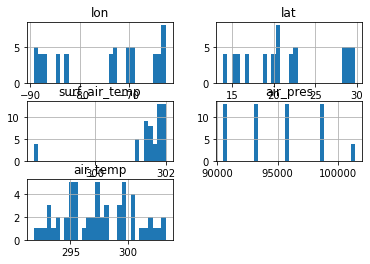

In [8]:
df_h=df[df['air_temp'] > 0.0]
hist = df_h.hist(bins=30)
hist

Text(0.5, 0, 'Air Pres')

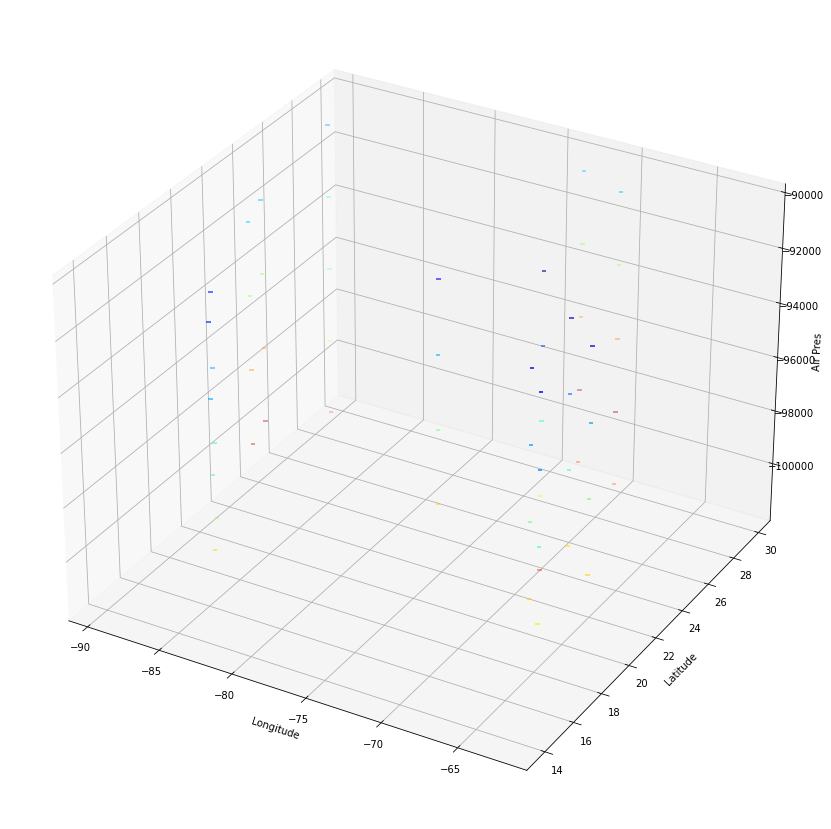

In [9]:
#
# For interactive to work
#
# 
# conda install -c conda-forge ipympl
#
#

import IPython

from IPython.display import display, HTML
%matplotlib inline
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(projection='3d')
xs = df['lon']
ys = df['lat']
zs = 0 - df['air_pres']
ax.scatter(xs, ys, zs, marker=1, c = df['air_temp'], cmap = 'jet',)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Air Pres')

#plt.show()


In [10]:
# Subset by altitude, aggregate to 10th of 1 degree.

q="""
select lon, lat, air_pres, avg_air_temp
from (
select
 round(lon, -1) lon,
 round(lat, -1) lat,
 h.air_pres,
 avg(case when is_nan(h.air_temp) then 0.0 else h.air_temp end) avg_air_temp
from 
 sci.climcaps c cross join
 unnest (c.air_pres_vars) t(h)
-- FROM dataset, UNNEST(items) t(sites)
where
 h.air_temp_qc = '0'
 and h.air_pres > 20000.0 
 and lon between -180 and 0
 and lat  between 0 and 90
group by 1,2,3
order by 1,2,3
) t
"""
conn = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2')
pd.options.display.float_format = '{:,.0f}'.format
df = pd.read_sql(q, conn)
df

,lon,lat,air_pres,avg_air_temp
0,-180,0,"20,099",220
1,-180,0,"21,203",223
2,-180,0,"22,344",226
3,-180,0,"23,523",229
4,-180,0,"24,741",232
...,...,...,...,...
8128,-0,90,"90,487",269
8129,-0,90,"93,152",269
8130,-0,90,"95,859",269
8131,-0,90,"98,607",270


In [11]:
df['air_pres'] = 0 - df['air_pres']

In [12]:
#fig = plt.figure(figsize=(18,15))
#ax = fig.add_subplot(projection='3d')
#xs = df['lon']
#ys = df['lat']
#zs = df['air_pres']
#ax.scatter(xs, ys, zs, marker=1, c = df['avg_air_temp'], cmap = 'jet',)

#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')
#ax.set_zlabel('Air Pres')

#plt.show()

In [13]:
#df.loc[df['column_name'] == some_value]
df_p=df.loc[df['avg_air_temp'] > 0.07]
df_p['mark']=0
df_p

,lon,lat,air_pres,avg_air_temp,mark
0,-180,0,"-20,099",220,0
1,-180,0,"-21,203",223,0
2,-180,0,"-22,344",226,0
3,-180,0,"-23,523",229,0
4,-180,0,"-24,741",232,0
...,...,...,...,...,...
8128,-0,90,"-90,487",269,0
8129,-0,90,"-93,152",269,0
8130,-0,90,"-95,859",269,0
8131,-0,90,"-98,607",270,0


In [14]:
import plotly.express as px
fig = px.scatter_3d(df_p, x='lon', y='lat', z='air_pres',
                    color='avg_air_temp', symbol='mark', opacity=0.35)
#fig.show("notebook")
fig.write_html("climcaps_avgairtemp_3d_scatter" + ".html")
#fig.show()

In [15]:
q="""
select
 lon,
 lat,
 h.air_pres,
 h.air_temp
from 
 sci.climcaps c cross join
 unnest (air_pres_vars) t(h)
where
 sat_name_part = 'n20'
 and obs_date_part = '2021-08-21'
 and asc_flag = '1'
 and h.air_temp_qc = '0'
 and lon between -180 and -0
 and lat between 0 and 90
-- and h.mw_spec_hum >= 0.005
"""
df=q2df(q)
#df




64ee38bd-05a3-4897-b54b-acd92f9f98a0 <Future at 0x7faeb05d2710 state=running>
SUCCEEDED
Execution Time: 10350
64ee38bd-05a3-4897-b54b-acd92f9f98a0.csv


In [16]:
q="""
select 
 sat_name_part, lon, lat, apv.air_pres, apv.air_temp, apv.air_temp_err, apv.air_temp_qc
from 
 sci.climcaps c cross join
 unnest (c.air_pres_vars) t(apv) 
where
 obs_date_part between '2021-08-21' and '2021-08-23'
 and lon between -100 and -65
 and lat  between 17 and 34
 and apv.air_pres > 80000
 and apv.air_temp_qc = '0'
 and asc_flag = '1'
order by
 lon, lat, apv.air_pres, sat_name_part"""
df=q2df(q)
df

8f3798fd-eef5-41c0-87fb-c620b624c2da <Future at 0x7faeb00d9b38 state=running>
SUCCEEDED
Execution Time: 3560
8f3798fd-eef5-41c0-87fb-c620b624c2da.csv


,sat_name_part,lon,lat,air_pres,air_temp,air_temp_err,air_temp_qc
0,n20,-100,31,"80,237",291,1,0
1,n20,-100,31,"82,737",293,1,0
2,n20,-100,31,"85,279",295,1,0
3,n20,-100,31,"87,862",298,1,0
4,n20,-100,31,"90,487",300,1,0
...,...,...,...,...,...,...,...
64016,aqua,-65,33,"90,487",293,1,0
64017,aqua,-65,33,"93,152",295,1,0
64018,aqua,-65,33,"95,859",298,1,0
64019,aqua,-65,33,"98,607",300,1,0


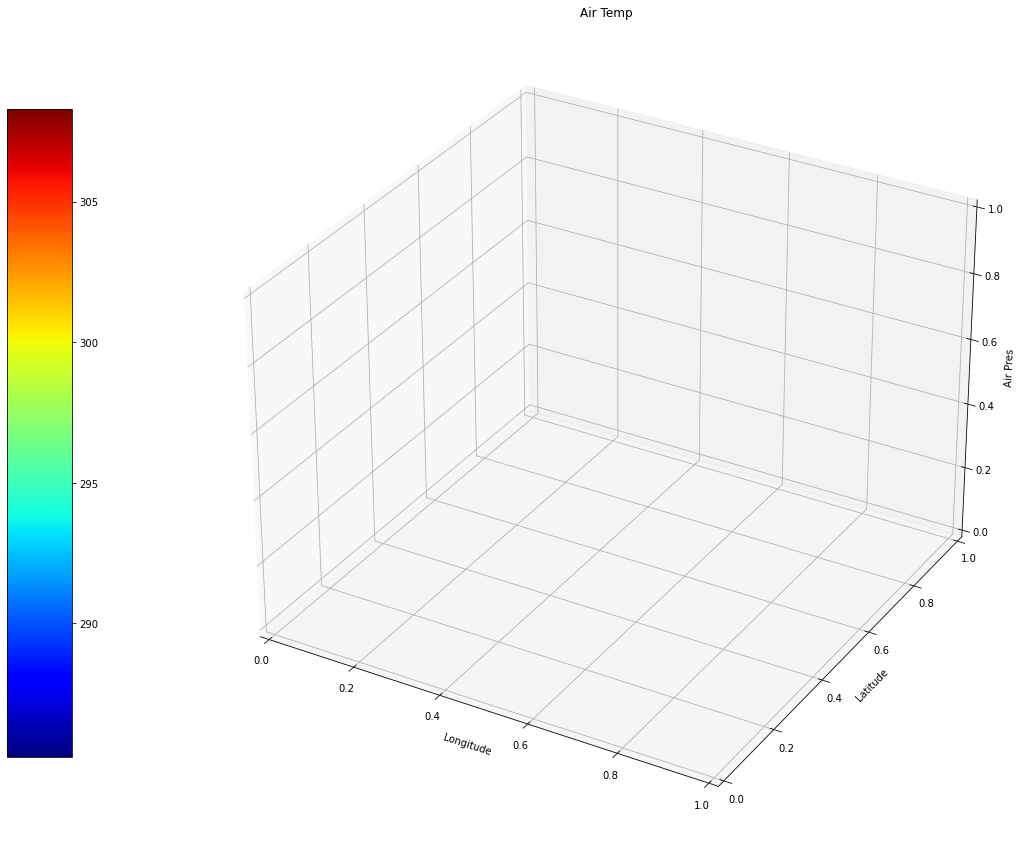

In [17]:
from matplotlib import colorbar, colors

df['air_pres'] = 0 - df['air_pres']

fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(projection='3d')
xs = df['lon']
ys = df['lat']
zs = df['air_pres']
ax.scatter(xs, ys, zs, marker=1, c = df['air_temp'], cmap = 'jet', alpha=0.75)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Air Pres')
ax.set_title('Air Temp')
ax = fig.add_axes([.05, .2, .05, .6]) # position of colorbar
cbar = colorbar.ColorbarBase(
    ax, 
    cmap=plt.get_cmap('jet'),
    norm=colors.Normalize( 
        vmin=min(df['air_temp']), 
        vmax=max(df['air_temp']) 
        )
    ) # set min, max of
#plt.show()




In [18]:
pd.options.display.float_format = '{:,.7f}'.format

array([[<AxesSubplot:title={'center':'air_temp'}>]], dtype=object)

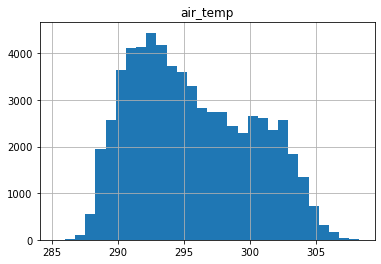

In [19]:
df_h=df[df['air_temp'] >= 0.0]
hist = df_h.hist(column='air_temp', range=(min(df['air_temp']), max(df['air_temp'])), bins=30)
hist

In [20]:
#df.loc[df['column_name'] == some_value]
df['mark']=0
df['air_pres']= 0 - df['air_pres']
df_p=df.loc[df['air_temp'] > 275]
#df_p=df.loc[df['mw_spec_hum'] > 0.02 & df['air_pres_h2o'] ==  87,862.03]

df_p

,sat_name_part,lon,lat,air_pres,air_temp,air_temp_err,air_temp_qc,mark
0,n20,-99.9915400,31.3870930,"80,237.1600000",290.8610000,0.9879178,0,0
1,n20,-99.9915400,31.3870930,"82,737.1500000",292.6486500,0.8744186,0,0
2,n20,-99.9915400,31.3870930,"85,278.8200000",295.0499600,1.1068014,0,0
3,n20,-99.9915400,31.3870930,"87,862.0300000",297.5528300,0.9851091,0,0
4,n20,-99.9915400,31.3870930,"90,486.6100000",300.1364000,1.2111188,0,0
...,...,...,...,...,...,...,...,...
64016,aqua,-65.0001450,32.6603300,"90,486.6100000",293.2684300,0.9708815,0,0
64017,aqua,-65.0001450,32.6603300,"93,152.3750000",295.4098800,0.8186440,0,0
64018,aqua,-65.0001450,32.6603300,"95,859.1300000",297.7995300,1.1264096,0,0
64019,aqua,-65.0001450,32.6603300,"98,606.6800000",300.1452300,0.9214100,0,0


In [21]:
import plotly.express as px
fig = px.scatter_3d(df_p, x='lon', y='lat', z='air_pres',
                    color='air_temp', symbol='mark', opacity=0.75)
#fig.show("notebook")
fig.write_html("climcaps_" + "tmp_gt_275_3d_scatter" + ".html")
#fig.show()

In [22]:
#df['air_pres'] = 0 - df['air_pres']
%matplotlib widget
plt.ion()

fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(projection='3d')
xs = df_p['lon']
ys = df_p['lat']
zs = df_p['air_pres']
#ax.scatter(xs, ys, zs, marker=1, c = df_p['air_temp'], cmap = 'jet',)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Air Pres')

#plt.show()

ModuleNotFoundError: No module named 'ipympl'

In [23]:
# Gas 
q="""
select
 lon,
 lat,
 asc_flag,
 air_pres_vars[87].air_pres air_pres,
 air_pres_vars[87].co2_vmr co2_vmr,
 air_pres_vars[87].co2_vmr_err co2_err
from 
 sci.climcaps c 
where
 sat_name_part = 'n20'
 and obs_date_part = '2021-08-21'
 and air_pres_vars[87].co2_vmr_qc = '0'
-- and air_pres_vars[87].co2_vmr >= 0.000410
-- and asc_flag = '0'
-- and lon between -180 and -0
-- and lat between 0 and 90
-- and h.mw_spec_hum >= 0.005
"""
df=q2df(q)
df

17966a1f-9d77-48b9-ba7c-ff339fa3d404 <Future at 0x7faeb09069b0 state=running>
SUCCEEDED
Execution Time: 4132
17966a1f-9d77-48b9-ba7c-ff339fa3d404.csv


,lon,lat,asc_flag,air_pres,co2_vmr,co2_err
0,-179.8630700,-57.3691560,0,"75,362.7700000",0.0004062,0.0000000
1,-179.8629800,-5.0980790,0,"75,362.7700000",0.0004090,0.0000000
2,-179.8623400,55.5857620,1,"75,362.7700000",0.0004087,0.0000000
3,-179.8604300,22.4157120,0,"75,362.7700000",0.0004084,0.0000000
4,-179.8592800,80.7235600,0,"75,362.7700000",0.0004097,0.0000000
...,...,...,...,...,...,...
244442,47.1950070,72.0466840,0,"75,362.7700000",0.0004085,0.0000000
244443,47.1960500,43.5955700,0,"75,362.7700000",0.0004084,0.0000000
244444,47.1984020,-12.9300920,0,"75,362.7700000",0.0004080,0.0000000
244445,48.0010400,-30.5861850,1,"75,362.7700000",0.0004090,0.0000000


In [26]:
pd.options.display.float_format = '{:,.9f}'.format
df_h=df
#hist = df_h.hist(bins=144)
#hist

#df[df['clim_co2_mmr'] != 0]

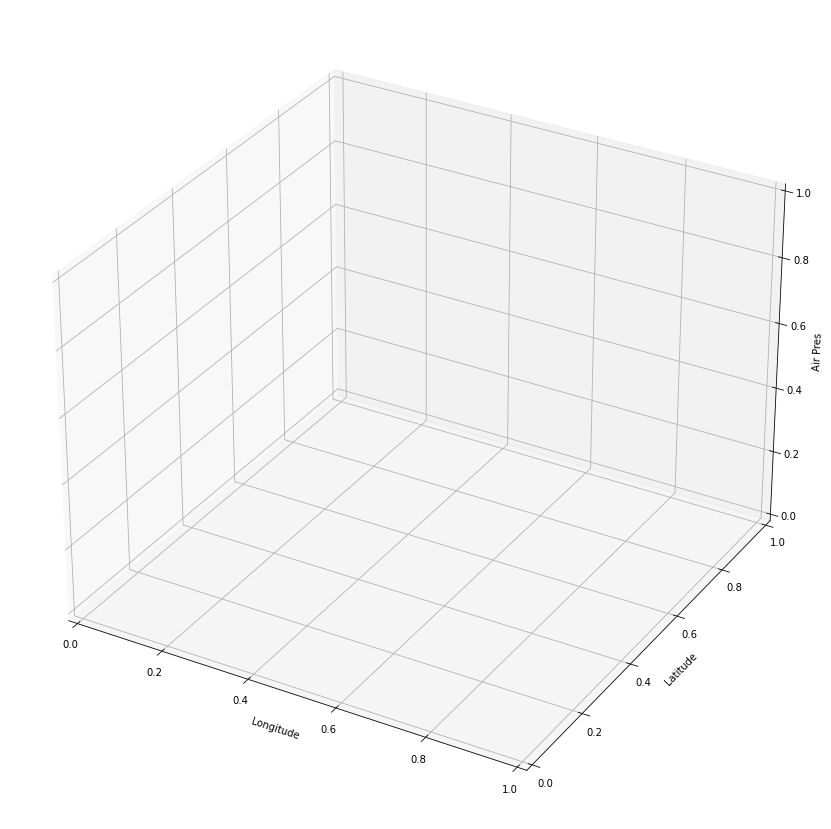

In [27]:
#df['air_pres'] = 0.0 - df['air_pres']
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(projection='3d')
xs = df['lon']
ys = df['lat']
zs = 1 #df['air_pres']
#ax.scatter(xs, ys, zs, marker=1, c = df['co2_vmr'], cmap = 'jet',)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Air Pres')

plt.show()

In [28]:
from matplotlib import colorbar, colors


fig = plt.figure(figsize=(18,15))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())



#ax.set_global()
ax.set_extent([-180, 180, -90, 90], crs=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

#plt.scatter(x=df['lon'], y=df['lat'],
#            c=df['co2_vmr'],
#            cmap=plt.get_cmap("jet"),
#            s=1,
#            alpha=0.5,
#            transform=crs.PlateCarree()) ## Important

ax = fig.add_axes([.05, .05, .05, .7]) # position of colorbar
cbar = colorbar.ColorbarBase(
    ax, 
    cmap=plt.get_cmap('jet'),
    norm=colors.Normalize( 
        vmin=min(df['co2_vmr']), 
        vmax=max(df['co2_vmr']) 
        )
    ) # set min, max of colorbar
#cbar.set_clim(-.5, .5) # set limits of color map

#plt.show()

NameError: name 'crs' is not defined

<Figure size 1296x1080 with 0 Axes>

In [29]:
from IPython.display import display, HTML
import plotly.express as px
import plotly.io as pio
#pio.kaleido.scope.mathjax = None
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)
pio.renderers.default='notebook'

fig=go.Figure()
#fig = px.scatter_mapbox(
#                        df, 
#                        lon="irwin_initialLongitude", 
#                        lat="irwin_initialLatitude", 
#                        hover_name="irwin_incidentname", 
#                        hover_data=["irwin_fireDiscoveryDateTime", "irwin_poostate", "filesDistributed"],
#                        color_discrete_sequence=["red"],
#                        size=[ 5 for i in range( df.shape[0] ) ],
#                        zoom=3)


fig = fig.add_trace(go.Scattermapbox(
    lon=round(df['lon'],3), 
    lat=round(df['lat'],3),
    mode='markers',
    marker=go.scattermapbox.Marker(
            size=8,
            opacity=0.5,
            color=df['co2_vmr'],
            cmax=max(df['co2_vmr']),
            cmin=min(df['co2_vmr']),
#            cmax=7.0,
#            cmin=-7.0,
            colorscale='Jet'
    ),
    name='co2_vmr August 21, 2021',
    text=['co2_vmr: ' + str(round(df["co2_vmr"][i],9)) + '<br>asc_flag: ' + str(df["asc_flag"][i])  for i, row in df.iterrows() ],
    hoverinfo='text'
    )
)

#fig = fig.add_trace(go.Scattermapbox(
#    lon=round(df_buoys['nbdc_longitude'],2), 
#    lat=round(df_buoys['nbdc_latitude'],2),
#    mode='markers',
#    marker=go.scattermapbox.Marker(
#            size=10,
#            color=round(df_buoys['tmp_diff_f'], 2),
#            cmax=20.0,
#            cmin=-10.0,
#            colorscale='Jet'
#    ),
#    name='Buoy',
#    text=[ 'Buoy time: ' + str( df_buoys["nbdc_obstime"][i] ) + '<br>Water Temperature (F): ' + str(round(df_buoys["nbdc_wtmp_f"][i],2))  for i in range(df_buoys.shape[0]) ],
#    hoverinfo='text'    )
#)

fig.update_layout(mapbox_style="open-street-map",  height=3000)
fig.update_layout(autosize=False, 
    width=2000, 
    height=1200,
    margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
    mapbox=dict(bearing=0, center=go.layout.mapbox.Center(lat=20, lon=-75),pitch=0,zoom=5)
)
#fig.show("notebook")
fig.write_html("map_" + "co2_vmr_1_layer" + ".html")
#fig.update_layout(zoom=10)
#fig.write_image("map_" + "sst_g16" + ".jpg", scale=3)
#pio.write_image(fig, file='map_sst_g16.jpg', format="jpg")

In [30]:
q="""
select
 lon,
 lat,
 air_pres_vars[97].air_pres air_pres,
 air_pres_vars[97].air_temp air_temp
from 
 sci.climcaps c -- cross join
-- unnest (air_pres_vars) t(h)
where
 sat_name_part = 'n20'
 and obs_date_part = '2021-08-21'
 and asc_flag = '1'
 and air_pres_vars[97].air_temp_qc = '0'
-- and lon between -180 and -0
-- and lat between 0 and 90
-- and h.mw_spec_hum >= 0.005
"""
df=q2df(q)
df

3ea6a310-74bd-4e5a-a1ed-38831e8f7a40 <Future at 0x7faea0681eb8 state=running>
SUCCEEDED
Execution Time: 2155
3ea6a310-74bd-4e5a-a1ed-38831e8f7a40.csv


,lon,lat,air_pres,air_temp
0,47.707123000,-27.692978000,"101,394.780000000",289.946620000
1,47.716170000,-44.368450000,"101,394.780000000",277.230700000
2,47.718044000,-25.723728000,"101,394.780000000",293.784270000
3,47.719826000,-29.657701000,"101,394.780000000",288.593960000
4,48.546750000,48.383457000,"101,394.780000000",307.136840000
...,...,...,...,...
35538,46.839790000,-45.956444000,"101,394.780000000",277.544680000
35539,46.816597000,-37.675823000,"101,394.780000000",284.900000000
35540,46.817318000,-30.323225000,"101,394.780000000",287.418180000
35541,46.817670000,-41.581990000,"101,394.780000000",280.137360000


In [31]:
fig = plt.figure(figsize=(24,21))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())



#ax.set_global()
ax.set_extent([-180, 180, -90, 90], crs=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

#plt.scatter(x=df['lon'], y=df['lat'],
#            c=df['air_temp'],
#            cmap=plt.get_cmap("jet"),
#            s=1,
#            alpha=0.5,
#            transform=crs.PlateCarree()) ## Important

ax = fig.add_axes([.05, .05, .05, .7]) # position of colorbar
cbar = colorbar.ColorbarBase(
    ax, 
    cmap=plt.get_cmap('jet'),
    norm=colors.Normalize( 
        vmin=min(df['air_temp']), 
        vmax=max(df['air_temp']) 
        )
    ) # set min, max of colorbar

NameError: name 'crs' is not defined

<Figure size 1728x1512 with 0 Axes>

In [32]:
# Gas 
q="""
select
 sat_name_part,
 air_pres,
 sum_co2_vmr/cnt_co2_vmr avg_c02_vmr,
 cnt_co2_vmr,
 min_co2_vmr,
 max_co2_vmr
from
(
select
 sat_name_part,
 h.air_pres,
 sum(case when h.air_temp_qc = '0' then 1 else 0 end ) air_temp_qc_0,
 sum(case when h.air_temp_qc = '1' then 1 else 0 end ) air_temp_qc_1,
 sum(case when h.air_temp_qc = '2' then 1 else 0 end ) air_temp_qc_2,
 avg(h.air_temp_err) air_temp_err_avg,
 sum(case when is_nan(h.co2_vmr) then 0 else h.co2_vmr end) sum_co2_vmr,
 sum(case when is_nan(h.co2_vmr) then 0 else 1 end) cnt_co2_vmr,
 min(h.co2_vmr) min_co2_vmr,
 max(h.co2_vmr) max_co2_vmr
from 
 sci.climcaps c cross join
 unnest (air_pres_vars) t(h)
where
 sat_name_part = 'n20'
 and obs_date_part = '2021-08-21'
 and asc_flag = '1'
group by
 sat_name_part, asc_flag, h.air_pres
order by
 h.air_pres desc, asc_flag, sat_name_part
) t
"""
df=q2df(q)
df

9b0a9789-05a1-4e6c-ae4e-2bd03486e01f <Future at 0x7faea01f2eb8 state=running>
SUCCEEDED
Execution Time: 2066
9b0a9789-05a1-4e6c-ae4e-2bd03486e01f.csv


,sat_name_part,air_pres,avg_c02_vmr,cnt_co2_vmr,min_co2_vmr,max_co2_vmr
0,n20,"110,000.016000000",nan,0,nan,nan
1,n20,"107,091.710000000",nan,0,nan,nan
2,n20,"104,223.210000000",0.000407814,19153,nan,nan
3,n20,"101,394.780000000",0.000407820,104568,nan,nan
4,n20,"98,606.680000000",0.000407818,129186,0.000368630,0.000429376
...,...,...,...,...,...,...
95,n20,22.440844000,0.000412733,160231,0.000379175,0.000450533
96,n20,13.695105000,0.000412747,160231,0.000377999,0.000450127
97,n20,7.687727000,0.000412763,160231,0.000377987,0.000449652
98,n20,3.838212000,0.000412783,160231,0.000377973,0.000449080


In [34]:
for i,r in df.iterrows():
    print (i,round(r['air_pres'],1), round(r['avg_c02_vmr'],7), r['cnt_co2_vmr'], r['min_co2_vmr'], r['max_co2_vmr'])

0 110000.0 nan 0 nan nan
1 107091.7 nan 0 nan nan
2 104223.2 0.0004078 19153 nan nan
3 101394.8 0.0004078 104568 nan nan
4 98606.7 0.0004078 129186 0.00036863046 0.00042937620000000004
5 95859.1 0.0004078 136523 0.00036946294 0.0004296768
6 93152.4 0.0004079 139934 0.00037030675 0.00042998142
7 90486.6 0.0004079 143155 0.00037116208 0.0004302902400000001
8 87862.0 0.0004079 145560 0.00037202919999999997 0.0004306033
9 85278.8 0.0004079 147215 0.00037010864 0.0004309207
10 82737.1 0.0004079 148558 0.0003706074 0.00043124252
11 80237.2 0.0004079 149816 0.00037111315999999997 0.00043156886
12 77779.0 0.0004079 150923 0.00037162605 0.0004318998
13 75362.8 0.000408 152083 0.00037214623 0.0004323497
14 72988.6 0.000408 153284 0.00037267387999999997 0.00043407242999999994
15 70656.6 0.000408 154667 0.00037320913 0.00043581985
16 68366.8 0.000408 155877 0.00037369637999999997 0.00043914830000000004
17 66119.2 0.000408 157329 0.00037126953 0.00044252558
18 63914.0 0.000408 158356 0.0003717585 0

In [35]:
q="""select
 lon,
 lat,
 asc_flag,
 h.air_pres,
 h.co2_vmr
from 
 sci.climcaps c cross join
 unnest (air_pres_vars) t(h)
where
 sat_name_part = 'n20'
 and obs_date_part = '2021-08-21'
-- and asc_flag = '1'
 and h.co2_vmr_qc = '0'
 and h.co2_vmr > 0.000420
-- and lon between -180 and -0
-- and lat between 0 and 90
-- and h.mw_spec_hum >= 0.005"""
df=q2df(q)


dffa324d-4244-4de8-be27-472222a967c8 <Future at 0x7fae8bca7da0 state=running>
SUCCEEDED
Execution Time: 2800
dffa324d-4244-4de8-be27-472222a967c8.csv


In [36]:
df

,lon,lat,asc_flag,air_pres,co2_vmr
0,49.752922000,-63.698383000,0,1.606382700,0.000420052
1,55.303997000,-70.831680000,1,270.087900000,0.000421158
2,55.303997000,-70.831680000,1,333.979100000,0.000422407
3,55.303997000,-70.831680000,1,407.701450000,0.000423580
4,55.303997000,-70.831680000,1,492.033630000,0.000424686
...,...,...,...,...,...
100468,41.327583000,-72.864100000,0,"25,996.918000000",0.000421286
100469,41.327583000,-72.864100000,0,"27,291.916000000",0.000421308
100470,41.327583000,-72.864100000,0,"28,626.176000000",0.000421331
100471,41.327583000,-72.864100000,0,"30,000.006000000",0.000421353


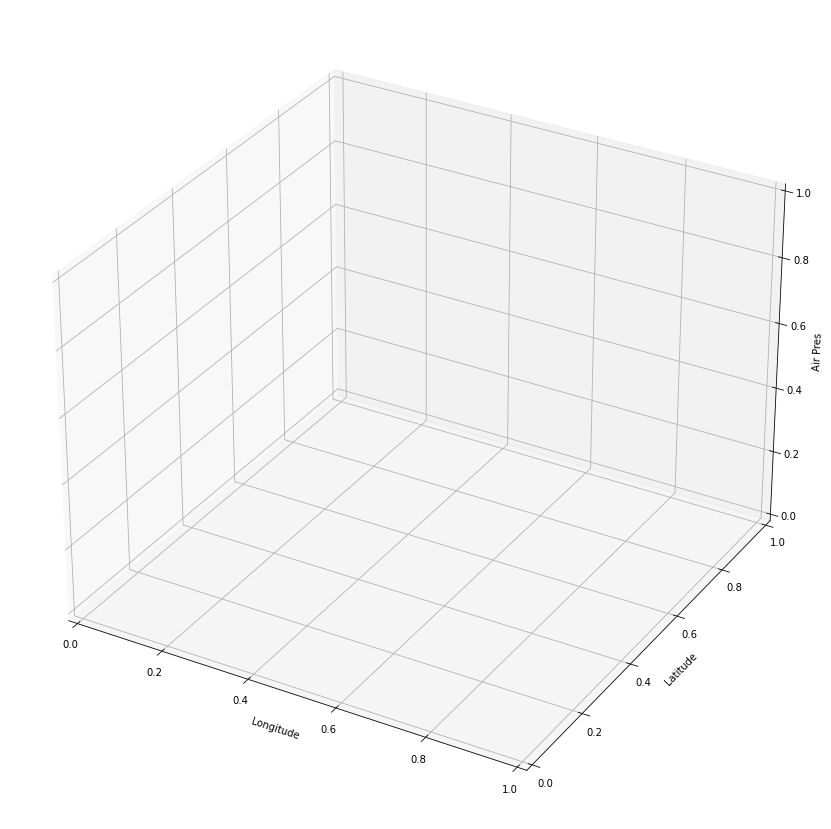

In [37]:
#df['air_pres'] = 0.0 - df['air_pres']
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(projection='3d')
xs = df['lon']
ys = df['lat']
zs = df['air_pres']
#ax.scatter(xs, ys, zs, marker=1, c = df['co2_vmr'], cmap = 'jet',)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Air Pres')

plt.show()

In [38]:
df['mark']=1
df['air_pres']=0-df['air_pres']
import plotly.express as px
fig = px.scatter_3d(df, x='lon', y='lat', z='air_pres',
                    color='co2_vmr', symbol='mark', opacity=0.35)
#fig.show("notebook")
fig.write_html("climcaps_" + "co2_3d_scatter" + ".html")
#fig.show()